In [27]:
import datasets
ds = datasets.load_from_disk("./taco_cleaned_exec_filtered_max75")
ds

Dataset({
    features: ['question', 'solutions', 'starter_code', 'input_output', 'difficulty', 'raw_tags', 'name', 'source', 'tags', 'skill_types', 'url', 'Expected Auxiliary Space', 'time_limit', 'date', 'picture_num', 'memory_limit', 'Expected Time Complexity'],
    num_rows: 7099
})

In [4]:
total_solns = 0
for ex in ds:
    total_solns += len(ex["solutions"])

total_solns

263704

/tmp/ipykernel_3379079/4160911719.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=ordered_difficulty_counts.index, y=ordered_difficulty_counts.values, palette=colors)


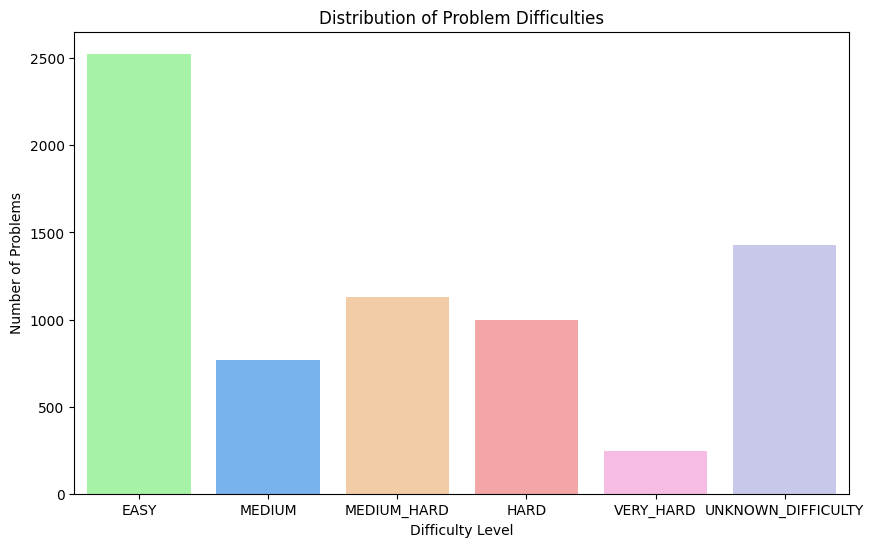

<Figure size 640x480 with 0 Axes>

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

df = ds.to_pandas()

difficulty_counts = df['difficulty'].value_counts()

order = ['EASY', 'MEDIUM', 'MEDIUM_HARD', 'HARD', 'VERY_HARD', 'UNKNOWN_DIFFICULTY']

ordered_difficulty_counts = pd.Series([difficulty_counts.get(level, 0) for level in order], index=order)

colors = ['#99ff99', '#66b3ff', '#ffcc99', '#ff9999', '#ffb3e6', '#c2c2f0']

plt.figure(figsize=(10, 6))
sns.barplot(x=ordered_difficulty_counts.index, y=ordered_difficulty_counts.values, palette=colors)
plt.title('Distribution of Problem Difficulties')
plt.xlabel('Difficulty Level')
plt.ylabel('Number of Problems')
plt.show()
plt.savefig("./plots/diff_distr.png")
plt.savefig("./plots/diff_distr.pdf")

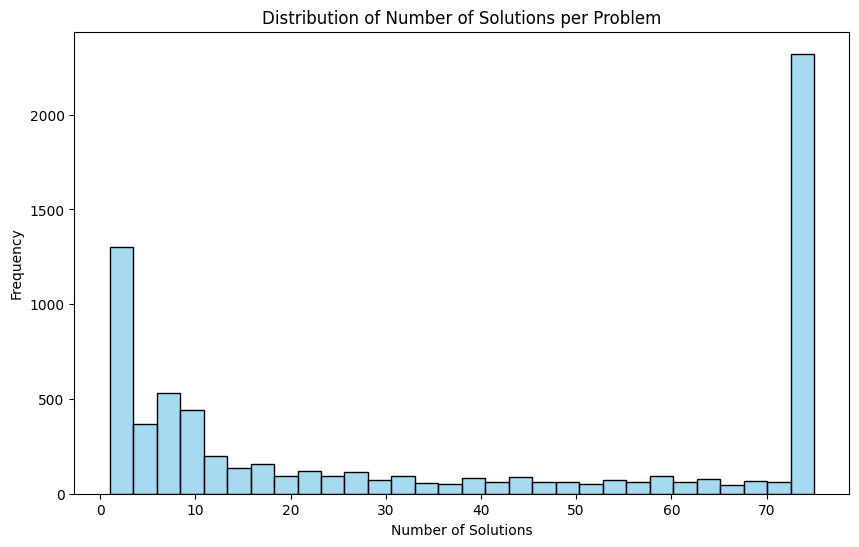

<Figure size 640x480 with 0 Axes>

In [24]:
num_solutions = ds.to_pandas()['solutions'].apply(len)

plt.figure(figsize=(10, 6))
sns.histplot(num_solutions, bins=30, color='skyblue')
plt.title('Distribution of Number of Solutions per Problem')
plt.xlabel('Number of Solutions')
plt.ylabel('Frequency')
plt.show()
plt.savefig("./plots/distr_solutions.png")
plt.savefig("./plots/distr_solutions.pdf")

Calculating BLEU Scores: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 7099/7099 [25:45<00:00,  4.59it/s]


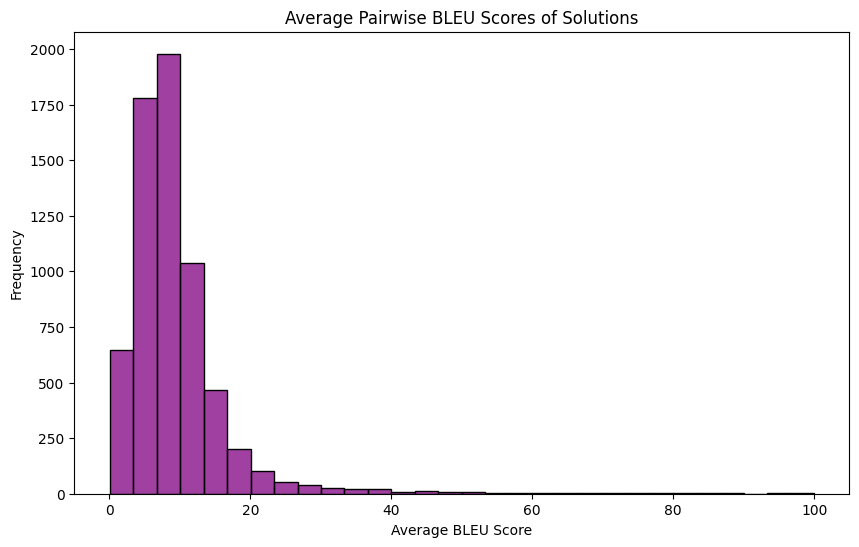

In [25]:
import sacrebleu
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

tqdm.pandas(desc="Calculating BLEU Scores")

def average_bleu_scores(solutions):
    if len(solutions) < 2:
        return np.nan
    scores = []
    for i in range(len(solutions)):
        for j in range(i + 1, len(solutions)):
            reference = solutions[i]
            candidate = solutions[j]
            score = sacrebleu.raw_corpus_bleu([candidate], [[reference]], .01).score
            scores.append(score)
    return np.mean(scores)

df = ds.to_pandas()

df['bleu_scores'] = df['solutions'].progress_apply(average_bleu_scores)

plt.figure(figsize=(10, 6))
sns.histplot(df['bleu_scores'].dropna(), bins=30, color='purple')
plt.title('Average Pairwise BLEU Scores of Solutions')
plt.xlabel('Average BLEU Score')
plt.ylabel('Frequency')
plt.show()

In [ ]:
plt.savefig("./plots/bleu_between_solutions.png")
plt.savefig("./plots/bleu_between_solutions.pdf")

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from transformers import AutoTokenizer
from tqdm.auto import tqdm

tqdm.pandas(desc="Tokenizing")

tokenizer = AutoTokenizer.from_pretrained("bigcode/starcoder2-15b")

def get_token_lengths(text):
    tokens = tokenizer.encode(text, truncation=True, max_length=2048)
    return len(tokens)

def process_solutions(solutions):
    return [get_token_lengths(solution) for solution in solutions]


question_token_lengths = ds.to_pandas()['question'].progress_apply(get_token_lengths)
solution_token_lengths = ds.to_pandas()['solutions'].progress_apply(process_solutions).explode()

combined_token_lengths = []
for question_length, solutions in zip(question_token_lengths, ds.to_pandas()['solutions']):
    combined_token_lengths.extend([question_length + len_ for len_ in process_solutions(solutions)])


Tokenizing: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7099/7099 [01:26<00:00, 82.02it/s]


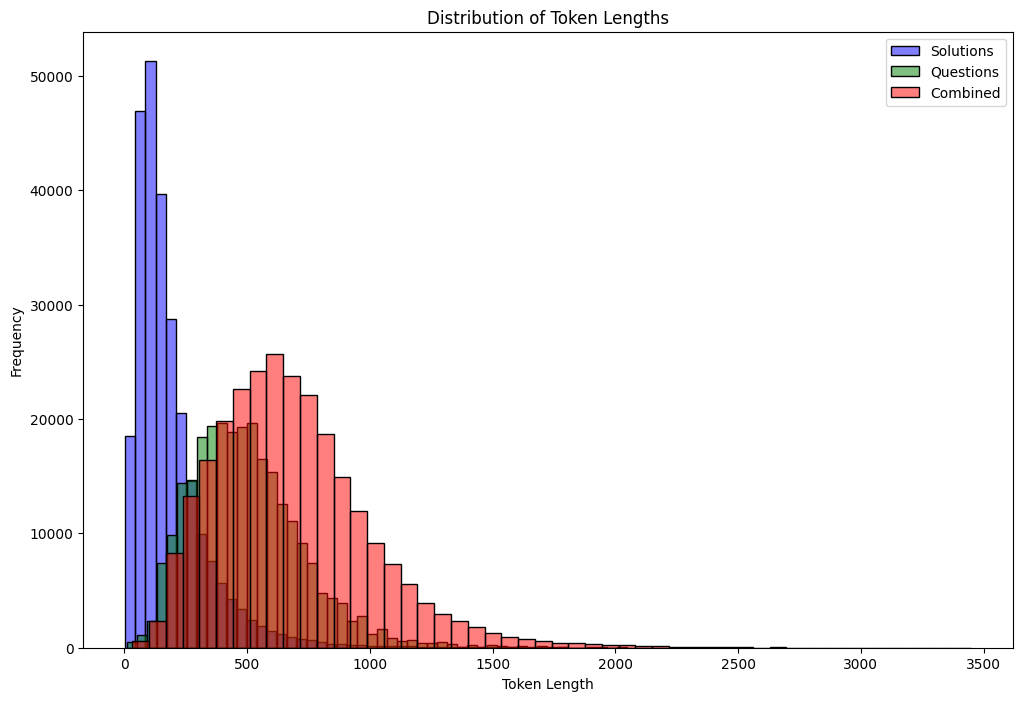

<Figure size 640x480 with 0 Axes>

In [20]:
token_lengths_df = pd.DataFrame({
    'Solution Token Lengths': solution_token_lengths,
    'Question Token Lengths': question_token_lengths,
    'Combined Token Lengths': combined_token_lengths
})

plt.figure(figsize=(12, 8))
sns.histplot(token_lengths_df['Solution Token Lengths'], bins=50, color='blue', alpha=0.5, label='Solutions')
sns.histplot(token_lengths_df['Question Token Lengths'], bins=50, color='green', alpha=0.5, label='Questions')
sns.histplot(token_lengths_df['Combined Token Lengths'], bins=50, color='red', alpha=0.5, label='Combined')
plt.title('Distribution of Token Lengths')
plt.xlabel('Token Length')
plt.ylabel('Frequency')
plt.legend()
plt.show()
plt.savefig("plots/distr_tokens.png")
plt.savefig("plots/distr_tokens.pdf")

Line counts sample (pre-explode): 0                         [41, 25, 34, 40, 46, 41, 23]
1                                             [37, 24]
2             [25, 23, 17, 16, 18, 16, 17, 20, 17, 24]
3        [22, 11, 8, 16, 20, 14, 27, 9, 17, 9, 27, 13]
4    [19, 20, 22, 19, 109, 23, 19, 16, 54, 26, 25, ...
Name: solutions, dtype: object
Exploded line counts sample: 0    41
0    25
0    34
0    40
0    46
Name: solutions, dtype: int64
DataFrame with line counts:    Lines of Code
0             41
0             25
0             34
0             40
0             46


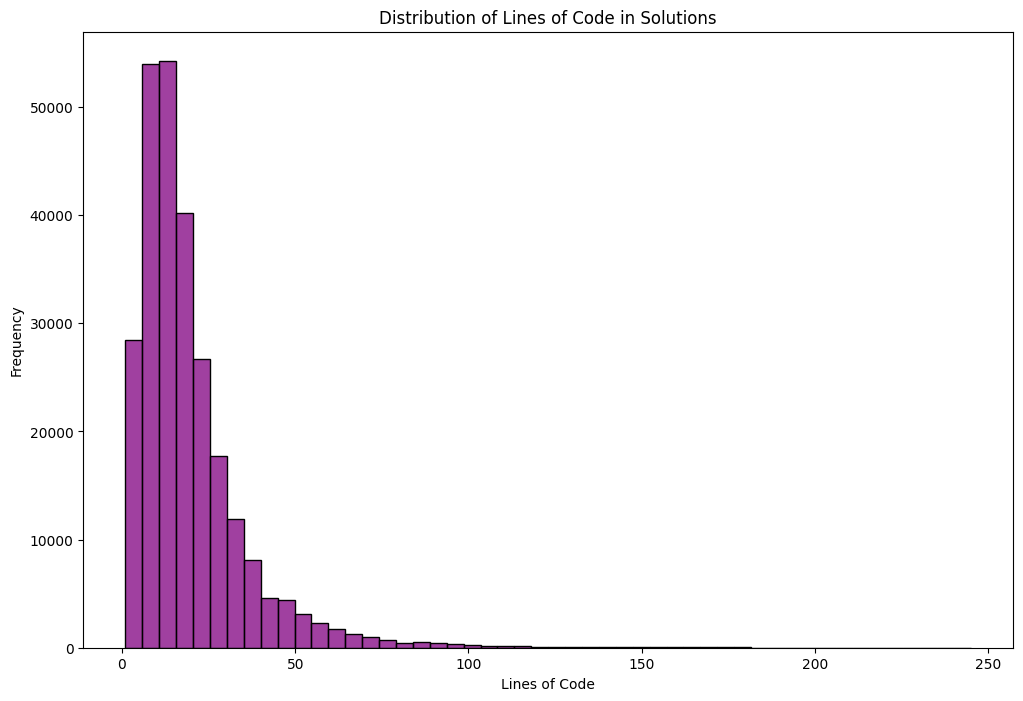

       Lines of Code
count  263704.000000
mean       19.450558
std        17.072433
min         1.000000
25%         9.000000
50%        15.000000
75%        24.000000
max       245.000000


In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Function to count lines in each solution
def count_lines(solutions):
    # +1 because the last line might not end with '\n'
    return [solution.count('\n') + 1 for solution in solutions]

# Assuming 'ds' is your dataset and is already loaded properly
# Apply line counting to 'solutions'
line_counts = ds.to_pandas()['solutions'].apply(count_lines)
print("Line counts sample (pre-explode):", line_counts.head())

# Explode the list of line counts into a flat series
exploded_line_counts = line_counts.explode().astype(int)  # Ensuring the data type is integer for plotting
print("Exploded line counts sample:", exploded_line_counts.head())

# Convert the exploded series to a DataFrame for easier handling
# This method directly uses the series as a column in the DataFrame
loc_df = pd.DataFrame({'Lines of Code': exploded_line_counts})
print("DataFrame with line counts:", loc_df.head())

# Ensure DataFrame is properly populated before plotting
if not loc_df.empty:
    # Plotting the distribution of lines of code
    plt.figure(figsize=(12, 8))
    sns.histplot(loc_df['Lines of Code'], bins=50, color='purple')
    plt.title('Distribution of Lines of Code in Solutions')
    plt.xlabel('Lines of Code')
    plt.ylabel('Frequency')
    plt.show()
else:
    print("The DataFrame is empty. Check the data transformations.")

print(loc_df.describe())

In [40]:
one_liners = []
for ex in ds:
    for sol in ex["solutions"]:
        nls = sol.count("\n") + 1
        if nls == 1 or nls == 2:
            one_liners.append((sol, ex))



In [45]:
print(one_liners[5][0])

(n, t) = (int(input()), sorted(set(map(int, input().split()))))
print('YES' if any((t[i + 2] - t[i] == 2 for i in range(len(t) - 2))) else 'NO')
